# [1D-BASELINE] Exp6: Fast Negative Swing LEFT

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
import datetime
import time
from IPython.display import clear_output

In [4]:
from grace.system import Grace
from grace.capture import LeftEyeCapture, RightEyeCapture
from grace.utils import get_center_chessboard_point, generate_triangle_wave

## Initialization

In [5]:
# Instantiation
grace = Grace(degrees=True)
left_cam = LeftEyeCapture()

[ROS Client] ROS Connection Successful at http://BodyNC-NUC:9090


In [6]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/569.4456315)  #LEFT: fx = 569.4456315. fy = 571.54490033
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "const_results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def slow_reset():
    grace.slow_move_left_eye_pan(angle=-8, step_size=0.0879, time_interval=0.015)
    state = grace.slow_centering_eyes()
    return state
    
def tilt_slow_reset():
    slow_reset()
    state = grace.move_left_eye((None, 0))
    return state
    
def generate_graphs(data, tilt, x_org):
    tilt_idx = tilt_arr.index(tilt)
    
    # Input Array
    plt.figure()
    input_arr  = data["input_arr"]
    plt.plot(input_arr, marker='.',)
    plt.ylim([-20, 20])
    plt.xlabel('Samples')
    plt.ylabel('Input Angle (deg)')
    plt.title('Input Motor Command')
    
    
    ### ('=============Initial Pixel===============')
    
    # Pixel vs Input Array (Raw)
    raw_x_pixel_arr = [x[0] for x in data["init_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_x_pixel_arr, color='orange', marker='.', linestyle="None")
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel X Value')
    plt.title('{Initial Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x_org-x[0] for x in data["init_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange', marker='.',  linestyle="None")
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel X Value (wrt 320 px)')
    plt.title('Initial Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x_org-x[0]) for x in data["init_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange", marker='.', linestyle="None")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Initial Pixel Robot Data')
    plt.grid()    
    
    # Histogram (Pixels)
    plt.figure()
    plt.hist(x_pixel_arr)
    plt.xlabel("pixels")
    plt.ylabel("n")
    plt.title("Initial Pixel Distribution")
    mean_val = np.mean(np.array(x_pixel_arr))
    std_val = np.std(np.array(x_pixel_arr))
    print("Init Mean (px):", mean_val)
    print("Init Std (px):", std_val)
    
    
    # Histogram (Angle)
    plt.figure()
    plt.hist(phi)
    plt.xlabel("degrees")
    plt.ylabel("n")
    plt.title("Initial Angle Distribution")
    mean_val = np.mean(np.array(phi))
    std_val = np.std(np.array(phi))
    print("Init Mean (deg):", mean_val)
    print("Init Std (deg):", std_val)
    
    
    ### ('=============Pixel===============')
    
    # Pixel vs Input Array (Raw)
    raw_x_pixel_arr = [x[0] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_x_pixel_arr, color='orange', marker='.', linestyle="None")
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel X Value')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x_org-x[0] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange', marker='.',  linestyle="None")
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel X Value (wrt 320 px)')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x_org-x[0]) for x in data["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange", marker='.', linestyle="None")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Robot Data')
    plt.grid() 
    
    # Histogram (Pixels)
    plt.figure()
    plt.hist(x_pixel_arr)
    plt.xlabel("pixels")
    plt.ylabel("n")
    plt.title("Target Pixel Distribution")
    mean_val = np.mean(np.array(x_pixel_arr))
    std_val = np.std(np.array(x_pixel_arr))
    print("Target Mean (px):", mean_val)
    print("Target Std (px):", std_val)
    
    
    # Histogram (Angle)
    plt.figure()
    plt.hist(phi)
    plt.xlabel("degrees")
    plt.ylabel("n")
    plt.title("Target Angle Distribution")
    mean_val = np.mean(np.array(phi))
    std_val = np.std(np.array(phi))
    print("Target Mean (deg):", mean_val)
    print("Target Std (deg):", std_val)
    

In [9]:
# Initialization

pickle_data = {
    "title": "[1D-BASELINE] EXP6_FastNegativeSwing",
    "description": None,
    "data_label": ["-16amp","-8amp","-4amp","-2amp"],
    "data": None,
    "datetime": datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
}

data_list = []

In [10]:
# Center the left eye

state = tilt_slow_reset()
pixel_state = get_center_chessboard_point(left_cam.frame)
print(state)
print(pixel_state)

(0.0, 0.0)
[316.3138427734375, 202.9353485107422]


## EXP6.1. -16 Degrees Amplitude

In [11]:
# Parameters

input = -11
trials = 10
time_interval = 0.015  # sec

tilt_arr = [0]

In [12]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep 
    "input_arr": [],  # Data points or Triangle Wave
    "init_arr": [],  # Initial data points as point of reference
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[-11, -11, -11, -11, -11, -11, -11, -11, -11, -11]


Text(0, 0.5, 'Input Angle (deg)')

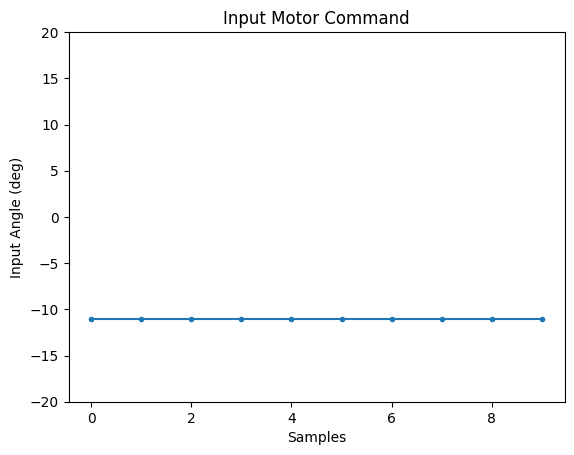

In [13]:
# Generation of triangle wave

input_arr = [input]*trials
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr, marker='.')
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [14]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
tilt_slow_reset()
time.sleep(0.75)


cnt = 0
for tilt in tilt_arr:
    init_arr = []
    pixel_arr = []
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)

        
        # Init Position
        in_cnt = 0
        while(in_cnt < 5):
            try:
                init_pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        init_arr.append(init_pixel_pt)
        
        
        # Fast Move
        state = grace.direct_move_left_eye((pan, tilt))
        time.sleep(0.75)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)

        
        # Slow Centering Eyes
        state = tilt_slow_reset()
        time.sleep(time_interval)
        
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    
    data["pixel_arr"].append(pixel_arr)
    data["init_arr"].append(init_arr)
    
    
    # End State
    tilt_slow_reset()
    time.sleep(0.75)
    data["end_motor_state"].append(grace.state)
    data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

print("Elapsed Time:", time.time()-start)

10/10
pan:-11, tilt:0
Elapsed Time: 67.56861424446106


In [15]:
# Checking of Data

data["init_arr"]

[[[316.4788513183594, 202.7815704345703],
  [316.3726501464844, 202.61968994140625],
  [316.50555419921875, 202.60919189453125],
  [316.3780212402344, 202.54774475097656],
  [316.28253173828125, 202.5291290283203],
  [316.7483215332031, 202.58441162109375],
  [316.53277587890625, 202.54432678222656],
  [316.5091857910156, 202.52529907226562],
  [316.5072326660156, 202.48768615722656],
  [315.9427490234375, 202.45819091796875]]]

In [16]:
# Checking of Data

data["pixel_arr"]

[[[499.603271484375, 202.07916259765625],
  [498.4273681640625, 201.37664794921875],
  [497.5420227050781, 201.4386444091797],
  [499.4465637207031, 201.87564086914062],
  [499.62896728515625, 201.87542724609375],
  [497.64984130859375, 201.36343383789062],
  [497.6009826660156, 201.34963989257812],
  [499.33343505859375, 201.75799560546875],
  [498.6506042480469, 201.4105987548828],
  [497.4521484375, 201.39283752441406]]]

Init Mean (px): 3.574212646484375
Init Std (px): 0.19929761111109687
Init Mean (deg): 0.35962096049115033
Init Std (deg): 0.020051844135085106
Target Mean (px): -178.5335205078125
Target Std (px): 0.8744031172240538
Target Mean (deg): -17.407301150348264
Target Std (deg): 0.0801051512209262


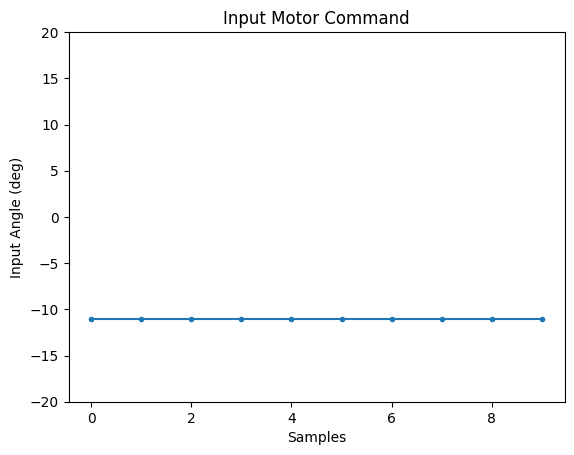

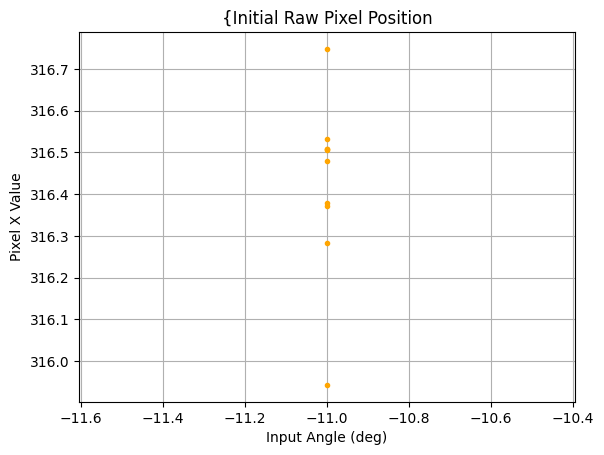

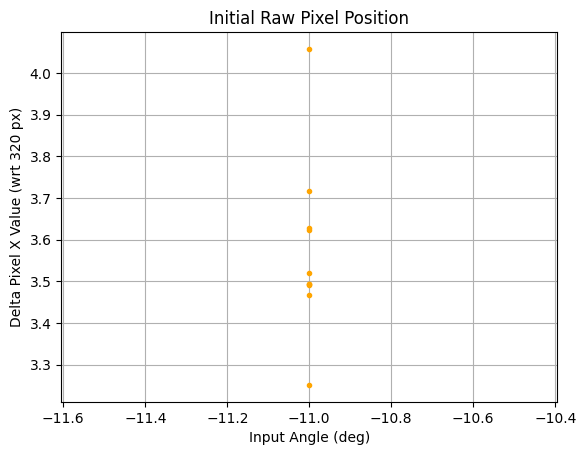

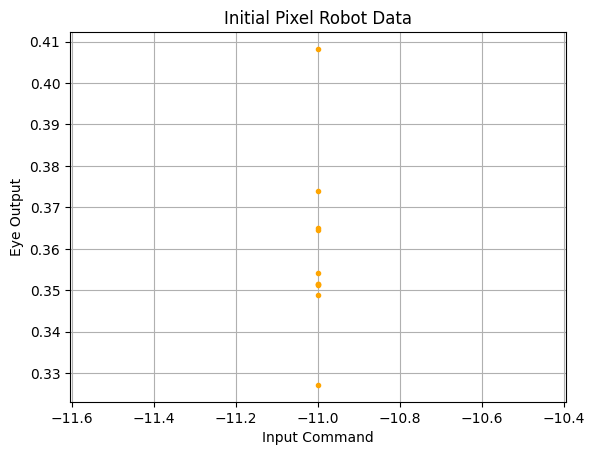

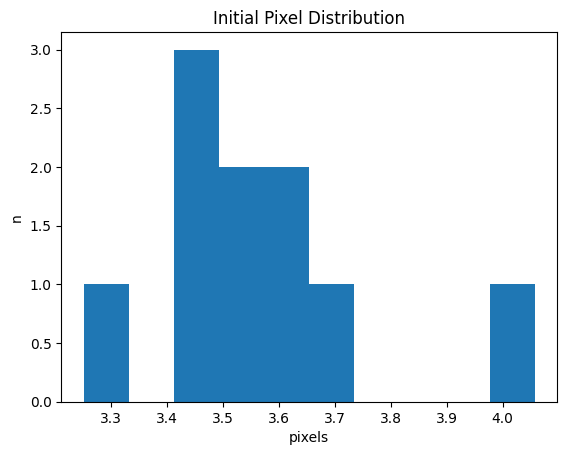

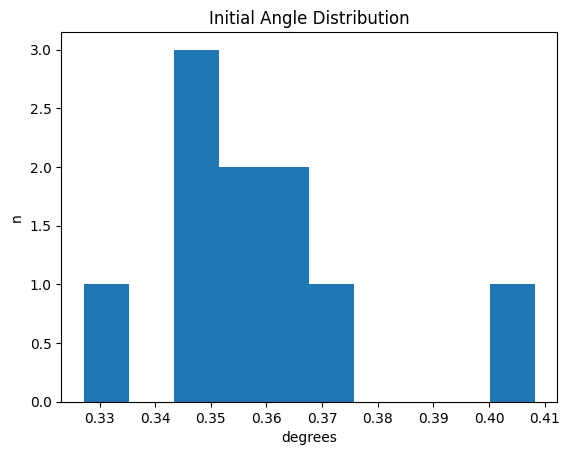

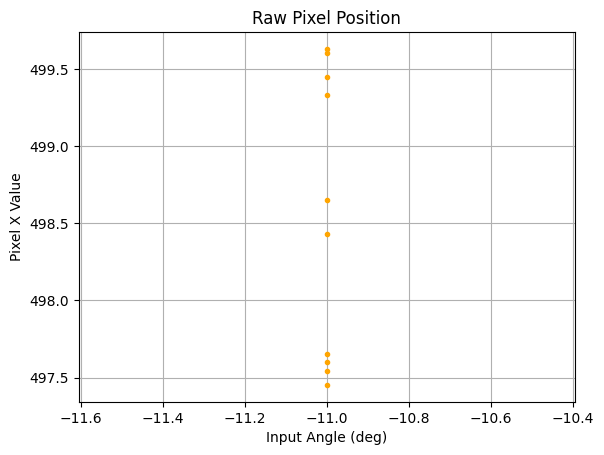

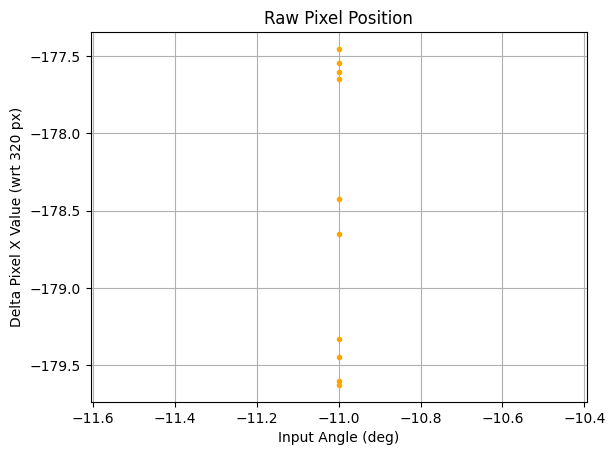

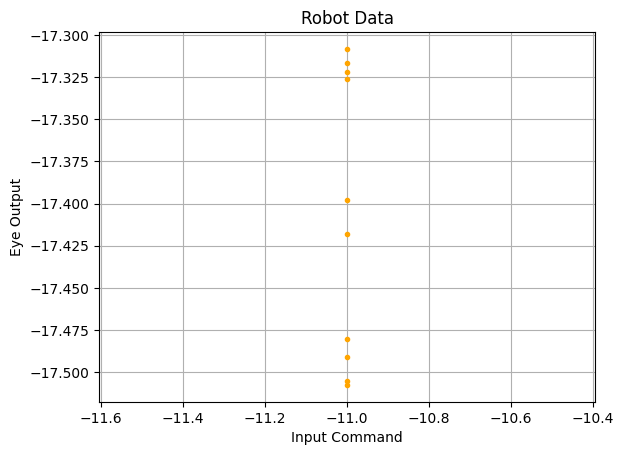

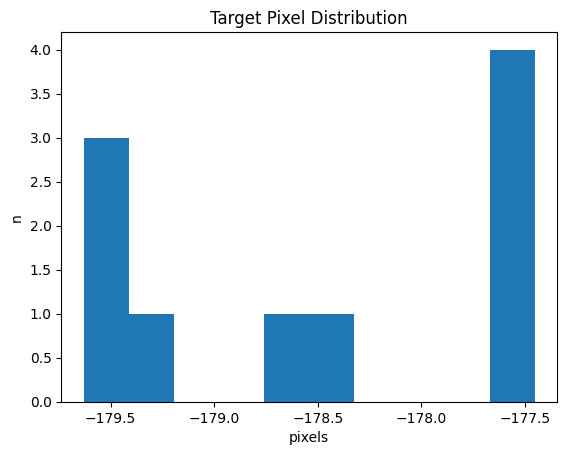

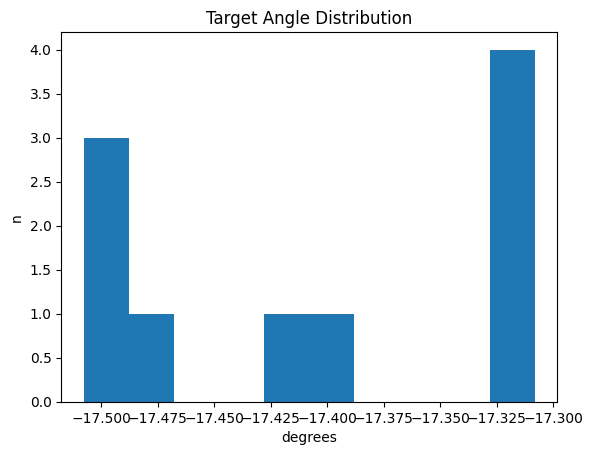

In [17]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=320)

In [18]:
# Saving to External Variable

data16 = data

In [19]:
# Appending to Data List

data_list.append(data16)

## EXP6.2. -8 Degrees Amplitude

In [20]:
# Parameters

input = -8
trials = 10
time_interval = 0.015  # sec

tilt_arr = [0]

In [21]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep 
    "input_arr": [],  # Data points or Triangle Wave
    "init_arr": [],  # Initial data points as point of reference
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[-8, -8, -8, -8, -8, -8, -8, -8, -8, -8]


Text(0, 0.5, 'Input Angle (deg)')

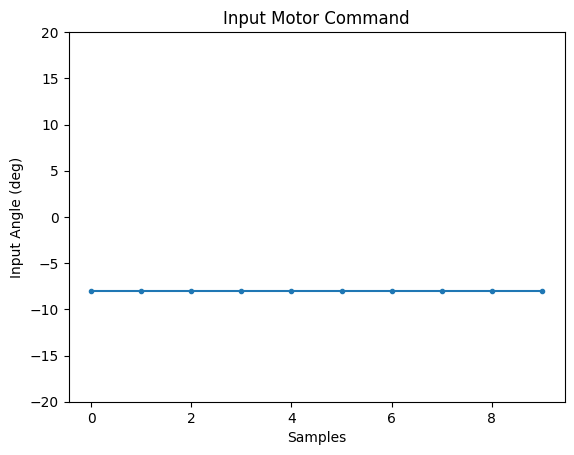

In [22]:
# Generation of triangle wave

input_arr = [input]*trials
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr, marker='.')
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [23]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
tilt_slow_reset()
time.sleep(0.75)


cnt = 0
for tilt in tilt_arr:
    init_arr = []
    pixel_arr = []
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)

        
        # Init Position
        in_cnt = 0
        while(in_cnt < 5):
            try:
                init_pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        init_arr.append(init_pixel_pt)
        
        
        # Fast Move
        state = grace.direct_move_left_eye((pan, tilt))
        time.sleep(0.75)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)

        
        # Slow Centering Eyes
        state = tilt_slow_reset()
        time.sleep(time_interval)
        
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    
    data["pixel_arr"].append(pixel_arr)
    data["init_arr"].append(init_arr)
    
    
    # End State
    tilt_slow_reset()
    time.sleep(0.75)
    data["end_motor_state"].append(grace.state)
    data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

print("Elapsed Time:", time.time()-start)

10/10
pan:-8, tilt:0
Elapsed Time: 60.41959595680237


In [24]:
# Checking of Data

data["init_arr"]

[[[315.69708251953125, 202.46791076660156],
  [316.34124755859375, 202.56854248046875],
  [316.55401611328125, 202.5747833251953],
  [316.45684814453125, 202.54132080078125],
  [316.4161376953125, 202.5665283203125],
  [316.09716796875, 202.47711181640625],
  [316.11163330078125, 202.5010986328125],
  [316.1499938964844, 202.50439453125],
  [316.23272705078125, 202.49473571777344],
  [316.70782470703125, 202.64788818359375]]]

In [25]:
# Checking of Data

data["pixel_arr"]

[[[443.1742858886719, 201.80625915527344],
  [445.5312805175781, 202.11764526367188],
  [444.1133117675781, 201.94888305664062],
  [443.4354553222656, 201.83901977539062],
  [444.38360595703125, 201.96400451660156],
  [445.30340576171875, 202.10348510742188],
  [445.6305236816406, 202.1092529296875],
  [443.2080383300781, 201.52891540527344],
  [442.9751281738281, 201.74842834472656],
  [444.0173645019531, 201.94268798828125]]]

Init Mean (px): 3.7235321044921874
Init Std (px): 0.2706026716751976
Init Mean (deg): 0.37464434422832354
Init Std (deg): 0.02722595526901477
Target Mean (px): -124.17723999023437
Target Std (px): 0.9605482072537845
Target Mean (deg): -12.301697769993435
Target Std (deg): 0.09224922040814233


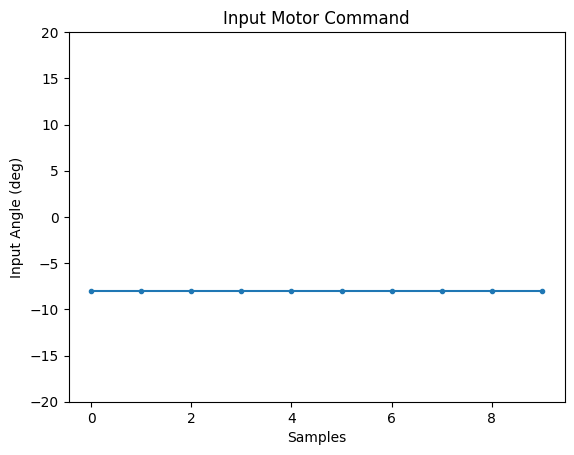

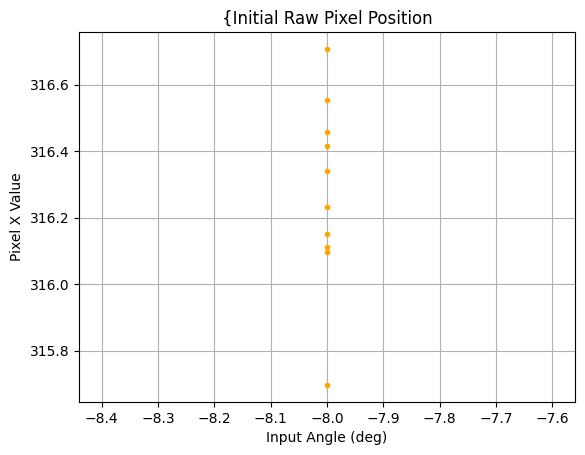

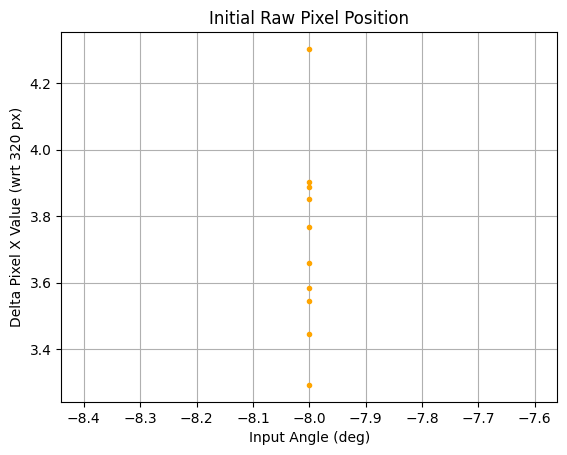

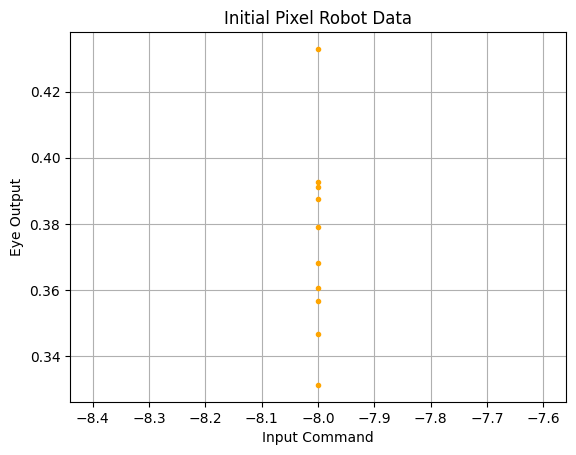

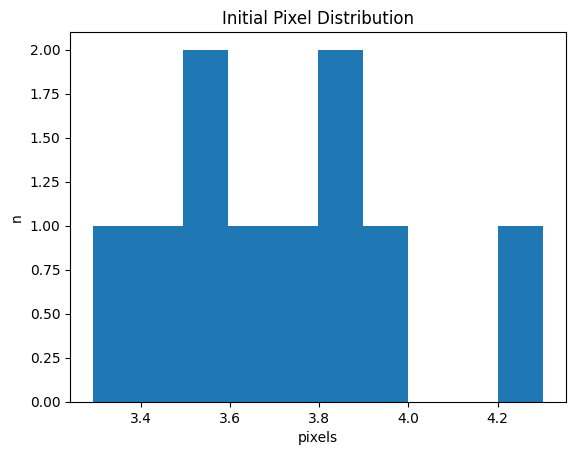

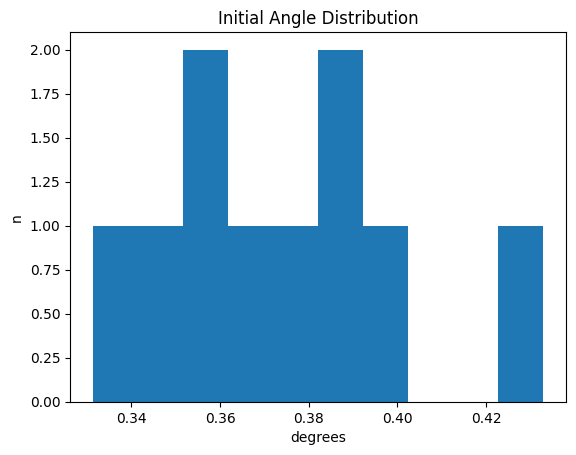

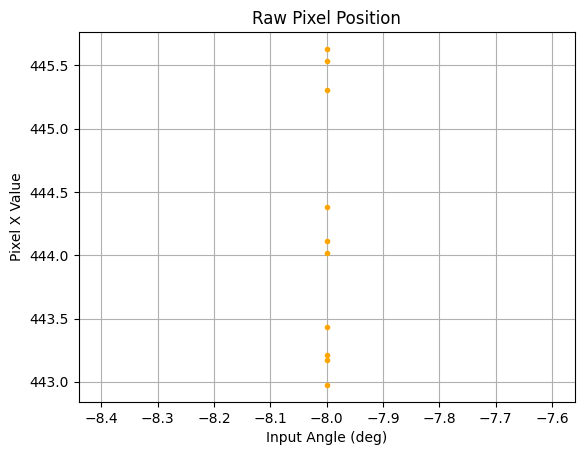

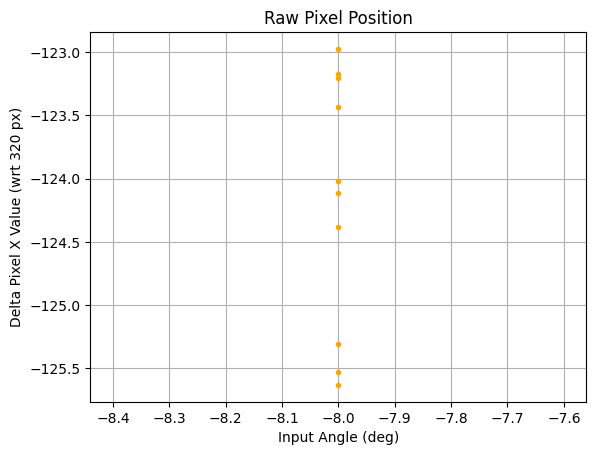

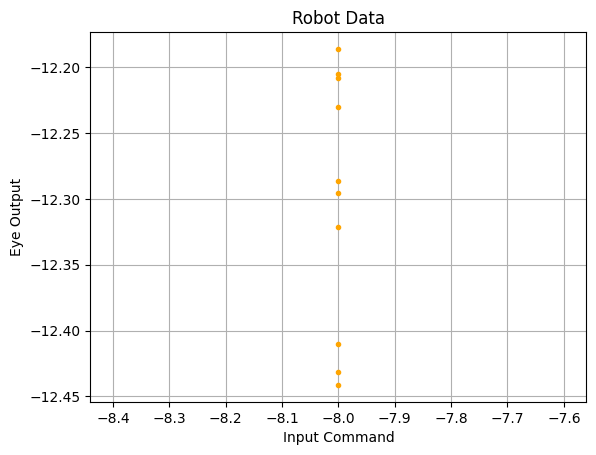

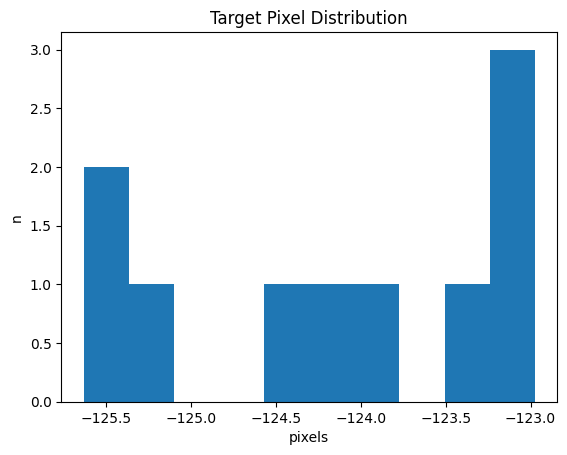

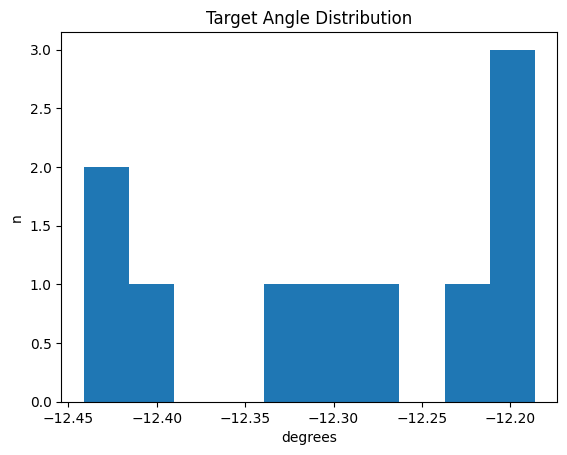

In [26]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=320)

In [27]:
# Saving to External Variable

data8 = data

In [28]:
# Appending to Data List

data_list.append(data8)

## EXP6.3. -4 Degrees Amplitude

In [29]:
# Parameters

input = -4
trials = 10
time_interval = 0.015  # sec

tilt_arr = [0]

In [30]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep 
    "input_arr": [],  # Data points or Triangle Wave
    "init_arr": [],  # Initial data points as point of reference
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[-4, -4, -4, -4, -4, -4, -4, -4, -4, -4]


Text(0, 0.5, 'Input Angle (deg)')

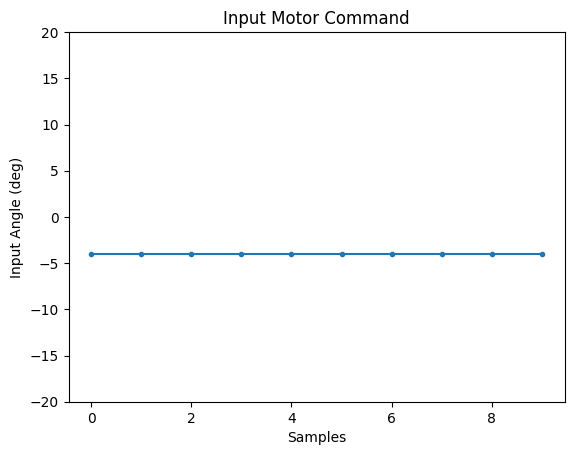

In [31]:
# Generation of triangle wave

input_arr = [input]*trials
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr, marker='.')
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [32]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
tilt_slow_reset()
time.sleep(0.75)


cnt = 0
for tilt in tilt_arr:
    init_arr = []
    pixel_arr = []
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)

        
        # Init Position
        in_cnt = 0
        while(in_cnt < 5):
            try:
                init_pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        init_arr.append(init_pixel_pt)
        
        
        # Fast Move
        state = grace.direct_move_left_eye((pan, tilt))
        time.sleep(0.75)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)

        
        # Slow Centering Eyes
        state = tilt_slow_reset()
        time.sleep(time_interval)
        
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    
    data["pixel_arr"].append(pixel_arr)
    data["init_arr"].append(init_arr)
    
    
    # End State
    tilt_slow_reset()
    time.sleep(0.75)
    data["end_motor_state"].append(grace.state)
    data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

print("Elapsed Time:", time.time()-start)

10/10
pan:-4, tilt:0
Elapsed Time: 68.4664945602417


In [33]:
# Checking of Data

data["init_arr"]

[[[316.48919677734375, 202.55963134765625],
  [316.4678955078125, 202.58914184570312],
  [316.105224609375, 202.5048370361328],
  [316.23309326171875, 202.51669311523438],
  [316.1649169921875, 202.5167999267578],
  [316.343017578125, 202.54006958007812],
  [316.1908874511719, 202.5284423828125],
  [315.8729553222656, 202.46206665039062],
  [316.2779846191406, 202.4920196533203],
  [316.46551513671875, 202.5550994873047]]]

In [34]:
# Checking of Data

data["pixel_arr"]

[[[376.54766845703125, 202.38905334472656],
  [375.49664306640625, 202.37759399414062],
  [381.2647399902344, 202.37234497070312],
  [381.0367736816406, 202.28289794921875],
  [376.18939208984375, 202.36439514160156],
  [381.1467590332031, 202.35214233398438],
  [381.3576965332031, 202.2600555419922],
  [377.3563537597656, 202.35809326171875],
  [380.37060546875, 202.28834533691406],
  [380.5036926269531, 202.2713165283203]]]

Init Mean (px): 3.7389312744140626
Init Std (px): 0.1826177479995449
Init Mean (deg): 0.37619373898691955
Init Std (deg): 0.018373592561105212
Target Mean (px): -59.12703247070313
Target Std (px): 2.2871731353915368
Target Mean (deg): -5.927835047389339
Target Std (deg): 0.22771517323715648


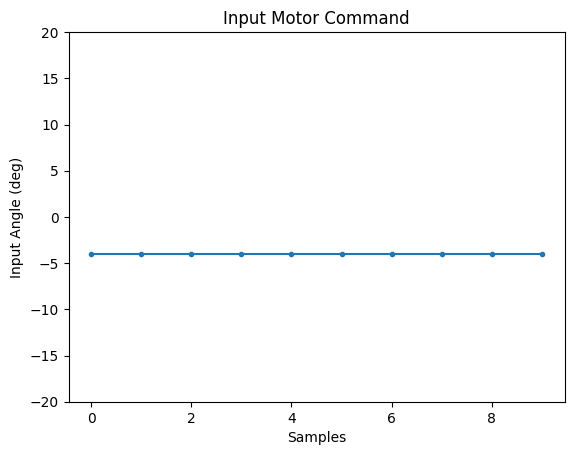

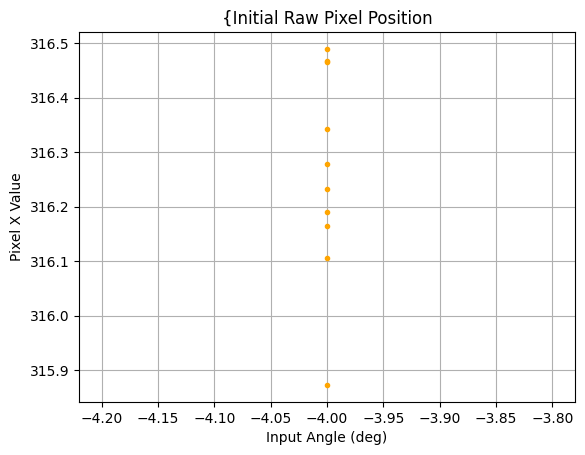

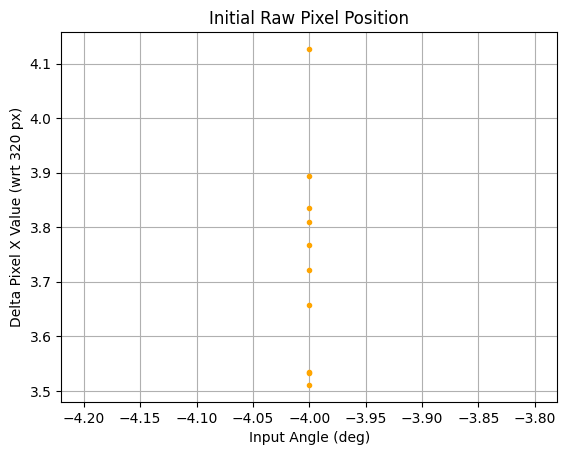

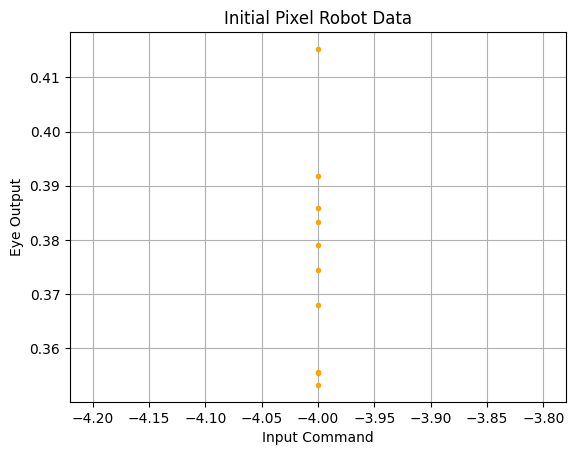

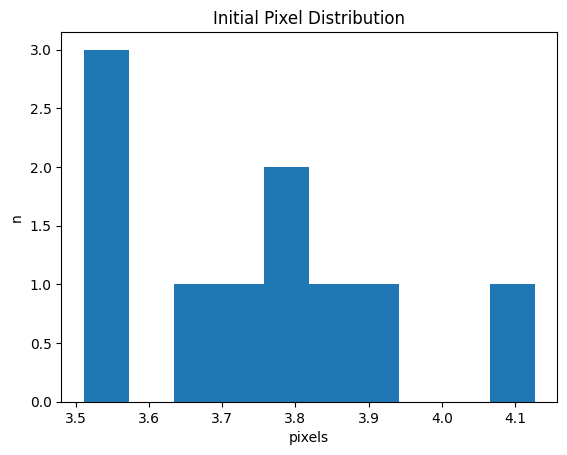

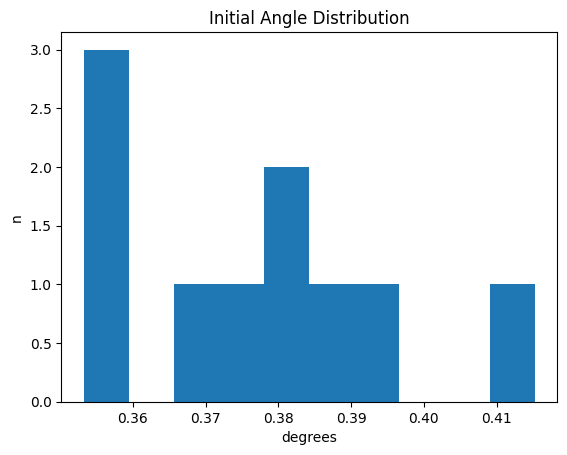

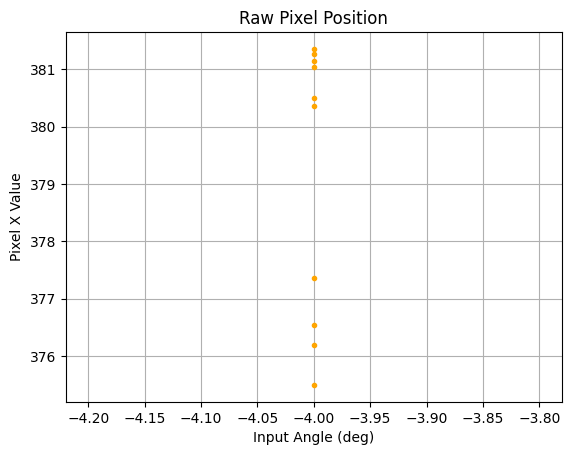

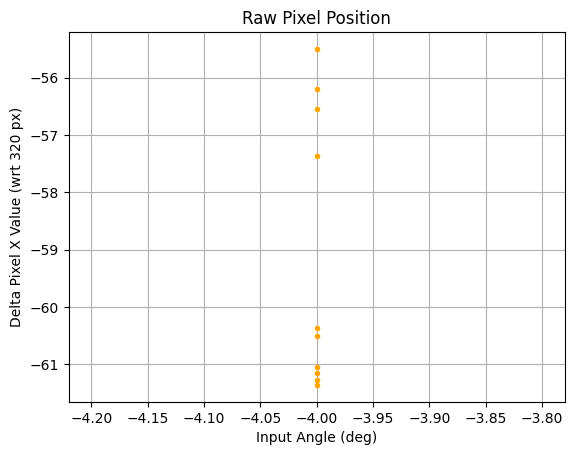

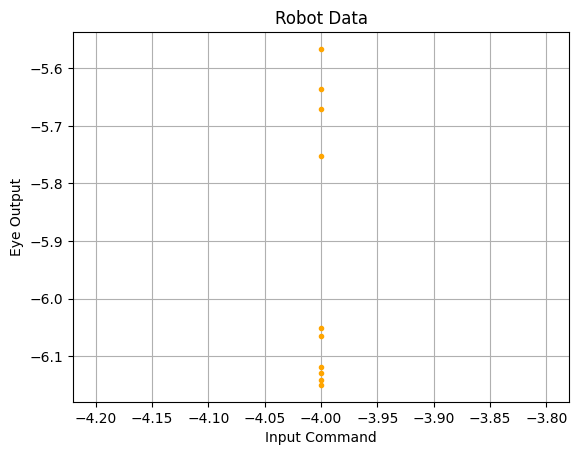

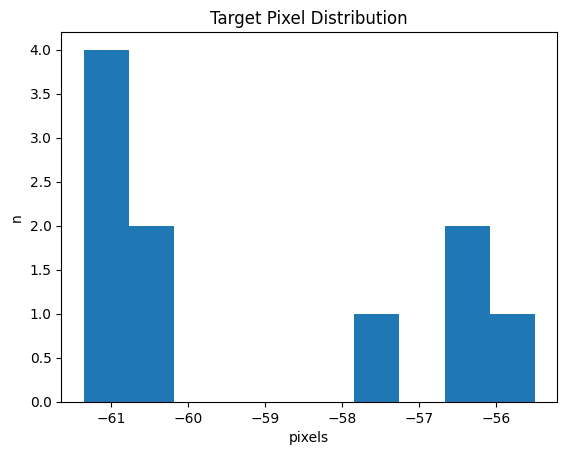

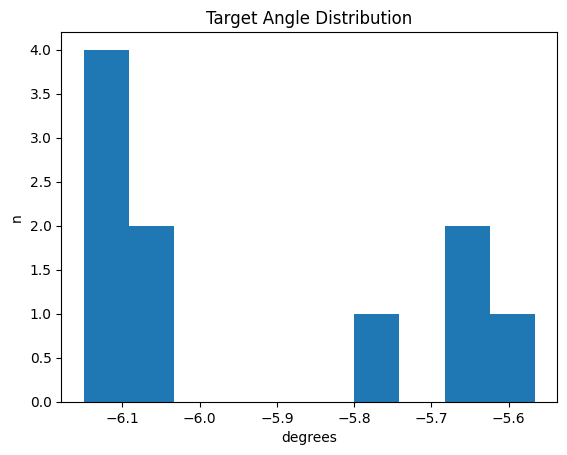

In [35]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=320)

In [36]:
# Saving to External Variable

data4 = data

In [37]:
# Appending to Data List

data_list.append(data4)

## EXP6.4. -2 Degrees Amplitude

In [38]:
# Parameters

input = -2
trials = 10
time_interval = 0.015  # sec

tilt_arr = [0]

In [39]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep 
    "input_arr": [],  # Data points or Triangle Wave
    "init_arr": [],  # Initial data points as point of reference
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2]


Text(0, 0.5, 'Input Angle (deg)')

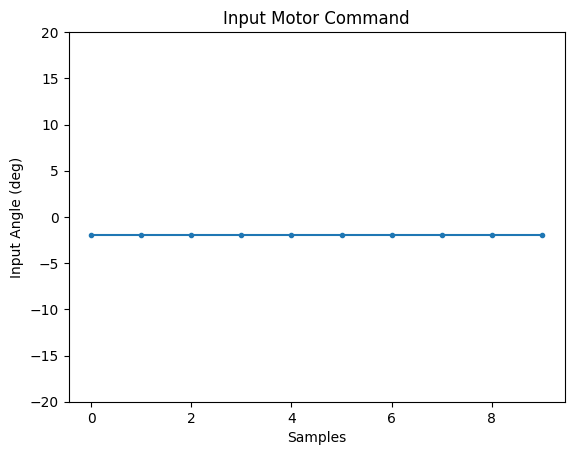

In [40]:
# Generation of triangle wave

input_arr = [input]*trials
print(input_arr)
plt.title('Input Motor Command')
plt.plot(input_arr, marker='.')
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [41]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
tilt_slow_reset()
time.sleep(0.75)


cnt = 0
for tilt in tilt_arr:
    init_arr = []
    pixel_arr = []
    data["initial_motor_state"].append(grace.state)
    data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)

        
        # Init Position
        in_cnt = 0
        while(in_cnt < 5):
            try:
                init_pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        init_arr.append(init_pixel_pt)
        
        
        # Fast Move
        state = grace.direct_move_left_eye((pan, tilt))
        time.sleep(0.75)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)

        
        # Slow Centering Eyes
        state = tilt_slow_reset()
        time.sleep(time_interval)
        
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    
    data["pixel_arr"].append(pixel_arr)
    data["init_arr"].append(init_arr)
    
    
    # End State
    tilt_slow_reset()
    time.sleep(0.75)
    data["end_motor_state"].append(grace.state)
    data["end_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

print("Elapsed Time:", time.time()-start)

10/10
pan:-2, tilt:0
Elapsed Time: 73.10573363304138


In [42]:
# Checking of Data

data["init_arr"]

[[[316.43048095703125, 202.55923461914062],
  [316.11383056640625, 202.5404815673828],
  [316.0450439453125, 202.50216674804688],
  [316.19903564453125, 202.50965881347656],
  [316.26904296875, 202.52044677734375],
  [316.1595458984375, 202.53829956054688],
  [316.38177490234375, 202.5612335205078],
  [316.0222473144531, 202.4801025390625],
  [315.7348327636719, 202.43338012695312],
  [315.9334411621094, 202.4647674560547]]]

In [43]:
# Checking of Data

data["pixel_arr"]

[[[347.746337890625, 202.4156951904297],
  [348.38104248046875, 202.45616149902344],
  [348.07574462890625, 202.38040161132812],
  [347.9099426269531, 202.39088439941406],
  [347.65447998046875, 202.37240600585938],
  [347.83331298828125, 202.35548400878906],
  [347.7667541503906, 202.36199951171875],
  [347.536376953125, 202.3627166748047],
  [347.8927001953125, 202.39064025878906],
  [348.1235656738281, 202.39942932128906]]]

Init Mean (px): 3.8710723876953126
Init Std (px): 0.19812164919502384
Init Mean (deg): 0.389488748831618
Init Std (deg): 0.01993342259934284
Target Mean (px): -27.892025756835938
Target Std (px): 0.2345423988525134
Target Mean (deg): -2.8041639408124146
Target Std (deg): 0.023542149187112196


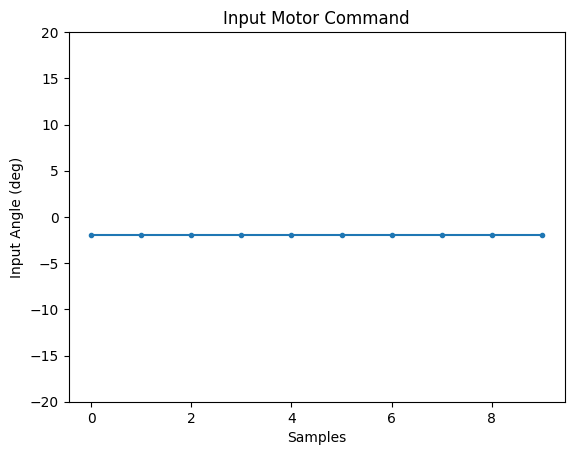

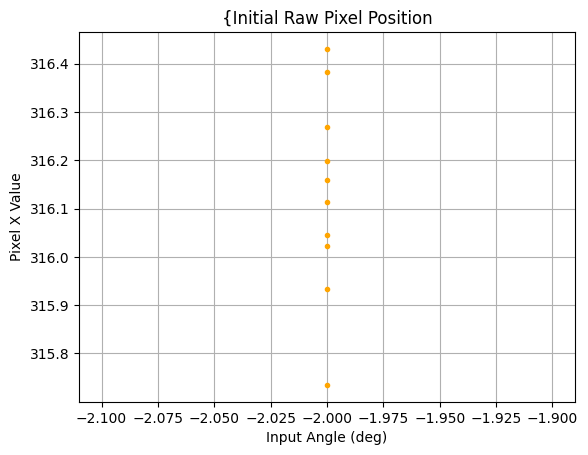

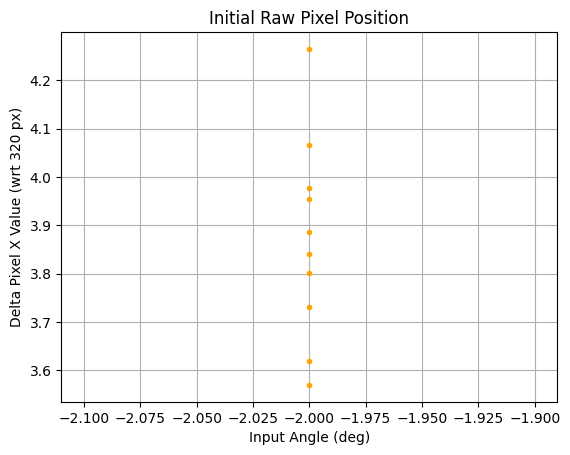

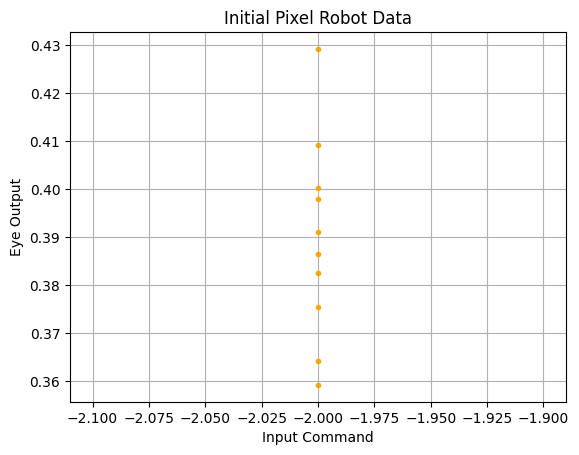

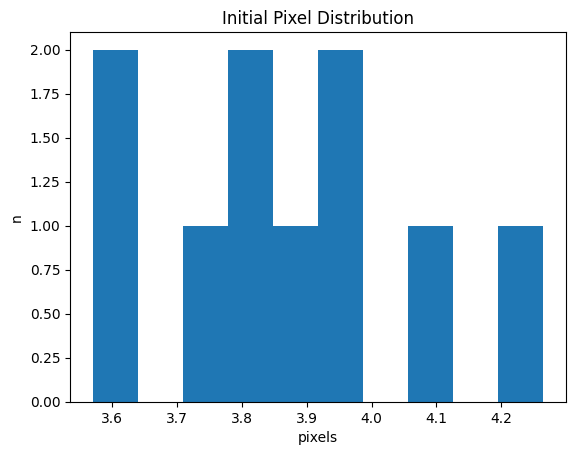

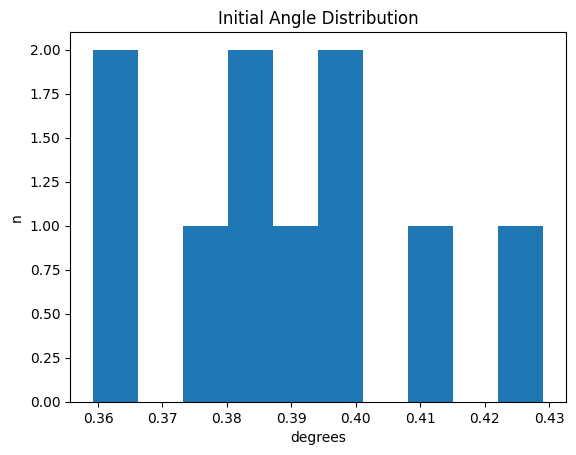

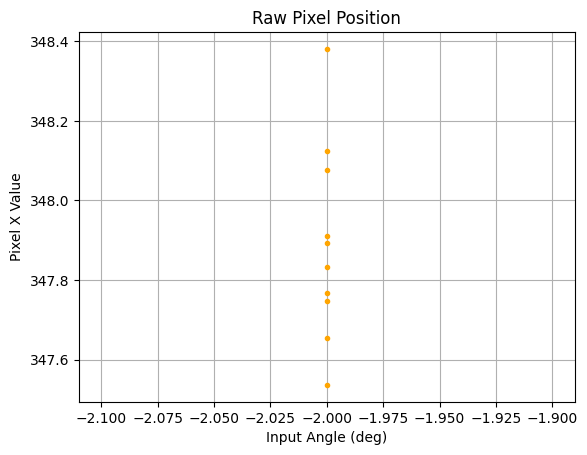

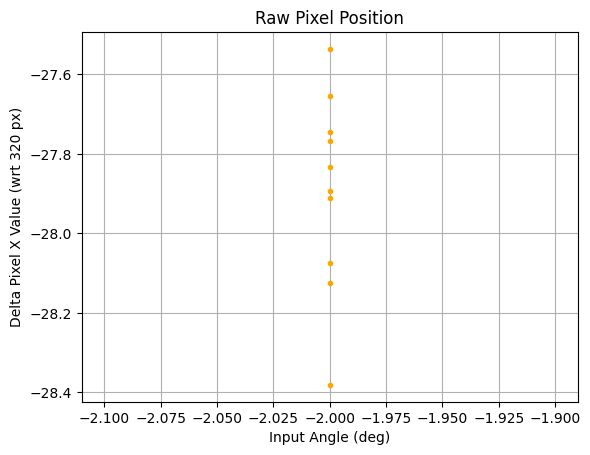

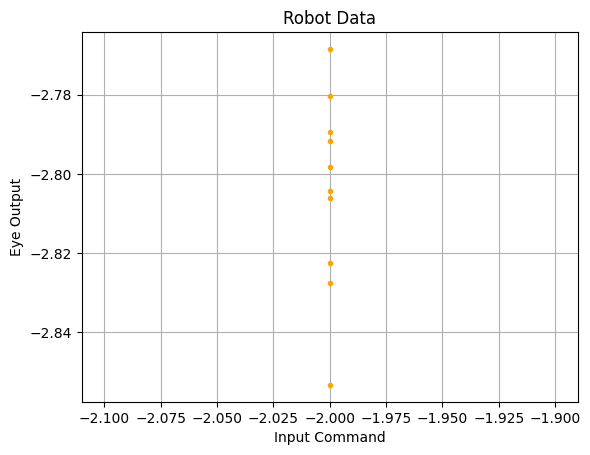

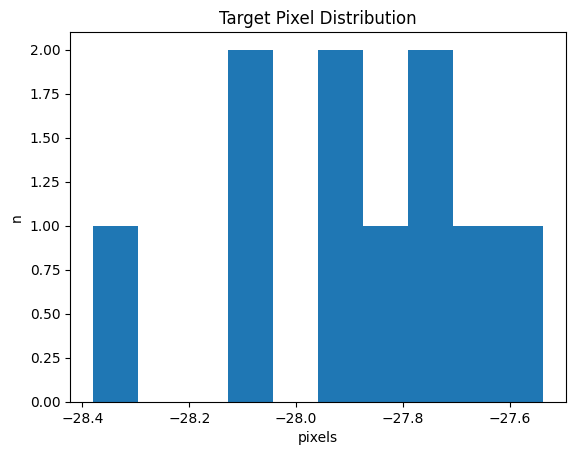

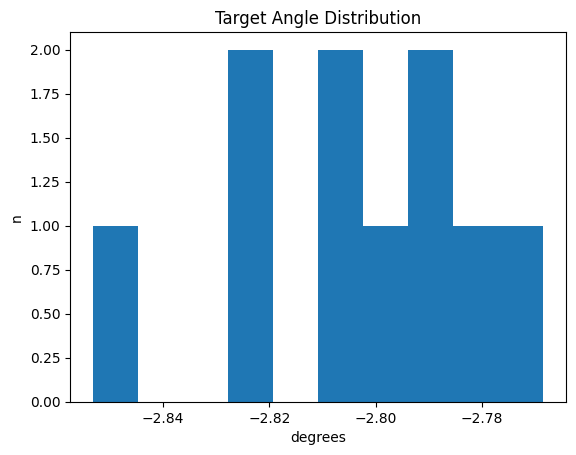

In [44]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=320)

In [45]:
# Saving to External Variable

data2 = data

In [46]:
# Appending to Data List

data_list.append(data2)

# Saving the Data

In [47]:
pickle_data["data"] = data_list
data_filepath = save_pickle_data(pickle_data, camera="left", name="1D-BASELINE_EXP6_FastNegativeSwing")

Data saved in: C:\dev\robot_control\const_results\20230530_005903_036222_left_1D-BASELINE_EXP6_FastNegativeSwing.pickle


# Loading the Data

In [48]:
# Opening of Pickle File

with open(data_filepath, 'rb') as file:
    data_load = pickle.load(file)

## Data Analysis

In [49]:
def random_colors(n):
    return np.random.rand(n,3)

rand_colors = random_colors(len(data_load["data"]))

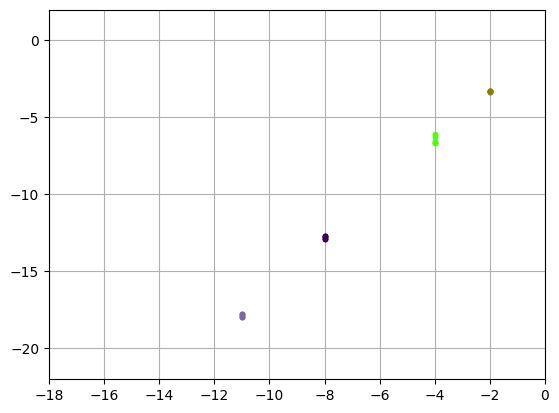

In [51]:
# Parameter
x_org = 315
tilt_idx = 0

for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
plt.xlim([-18, 0])
plt.ylim([-22, 2])
plt.grid()

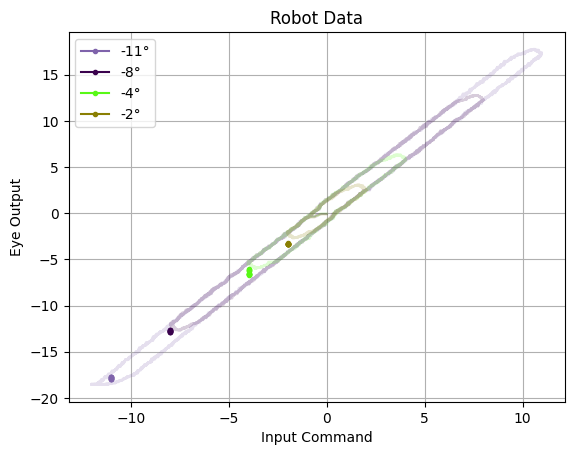

In [54]:
# Data Superposition

# Opening of Pickle File
filename = "20230530_002932_198169_left_1D-BASELINE_EXP4_RobotNegativeBaseline.pickle"
fn = os.path.join(os.path.abspath(".."), "const_results",filename)
with open(fn, 'rb') as file:
    baseline_data = pickle.load(file)

# Parameter
x_org = 315
tilt_idx = 0

# Data Captured
for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
plt.legend(["-11°", "-8°", "-4°", "-2°"])

# Line Data Parameters
for i in range(len(baseline_data["data"])):
    input_arr = baseline_data["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in baseline_data["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.2)
    
plt.xlabel('Input Command')
plt.ylabel('Eye Output')
plt.title('Robot Data')
plt.grid()

(-22.0, 2.0)

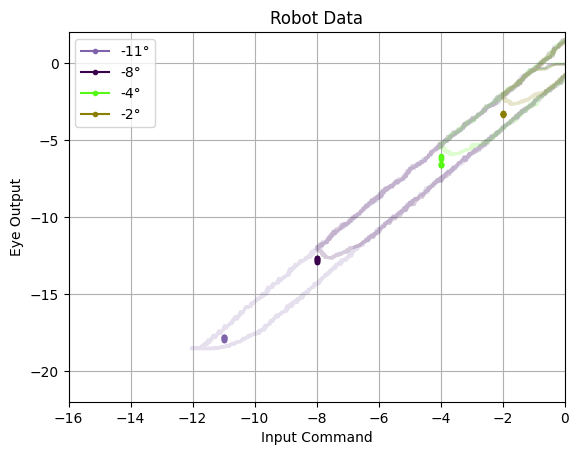

In [56]:
# Data Superposition

# Opening of Pickle File
filename = "20230530_002932_198169_left_1D-BASELINE_EXP4_RobotNegativeBaseline.pickle"
fn = os.path.join(os.path.abspath(".."), "const_results",filename)
with open(fn, 'rb') as file:
    baseline_data = pickle.load(file)

# Parameter
x_org = 315
tilt_idx = 0

# Data Captured
for i in range(len(data_load["data"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, marker='.', linestyle=None, color=rand_colors[i])
plt.legend(["-11°", "-8°", "-4°", "-2°"])

# Line Data Parameters
for i in range(len(baseline_data["data"])):
    input_arr = baseline_data["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in baseline_data["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, color=rand_colors[i], alpha=0.2)
    
plt.xlabel('Input Command')
plt.ylabel('Eye Output')
plt.title('Robot Data')
plt.grid()
plt.xlim([-16, 0])
plt.ylim([-22, 2])